# Benchmarking Results from Classification and Regression

#### Set Up

In [1]:
%pip install pandas_ta_classic
%pip install --upgrade pandas_ta_classic
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import site
import os

# Find the path to the pandas_ta_classic library and patch it
pandas_ta_classic_path = None
for sp in site.getsitepackages():
    pandas_ta_classic_path = os.path.join(sp, 'pandas_ta_classic')
    if os.path.exists(pandas_ta_classic_path):
        break

if pandas_ta_classic_path:
    squeeze_pro_path = os.path.join(pandas_ta_classic_path, 'momentum', 'squeeze_pro.py')
    if os.path.exists(squeeze_pro_path):
        try:
            with open(squeeze_pro_path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            fixed = False
            for line in lines:
                if "from numpy import NaN as npNaN" in line:
                    new_lines.append(line.replace("from numpy import NaN as npNaN", "# from numpy import NaN as npNaN\nimport numpy as np\n"))
                    fixed = True
                    print("Modified import statement in squeeze_pro.py")
                else:
                    new_lines.append(line)

            if fixed:
                with open(squeeze_pro_path, 'w') as f:
                    f.writelines(new_lines)
                print("Successfully patched pandas_ta_classic/momentum/squeeze_pro.py")
            else:
                print("Could not find the problematic import line in squeeze_pro.py")

        except Exception as e:
            print(f"Error modifying squeeze_pro.py: {e}")
    else:
        print(f"Could not find squeeze_pro.py at {squeeze_pro_path}")
else:
    print("Could not find the pandas_ta_classic library installation path.")

import pandas_ta_classic as ta

Could not find the problematic import line in squeeze_pro.py


In [3]:
%pip install torch
%pip install scikit-learn
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    precision_score, recall_score, f1_score, matthews_corrcoef,
    mean_squared_error, mean_absolute_error, r2_score, confusion_matrix,
    ConfusionMatrixDisplay
)

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from contextlib import nullcontext

import scipy

import random

import matplotlib.pyplot as plt

from unicodedata import bidirectional


In [5]:
def set_global_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seeds(42)

#### Confusion Matrix 

In [6]:
def compute_confusion(y_true, y_pred, labels=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    return cm

def plot_confusion(cm, labels, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(8,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, values_format=".2f" if cm.dtype.kind=='f' else "d", cmap='Blues', colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
def pct_str(x, decimals=1):
    return f"{x*100:.{decimals}f}%"    
    
def edge_labels_from_edges(edges, decimals=1):
    """
    Turn monotonic edges (len = C+1) into C human-readable labels, e.g.
    [-0.023, -0.006, 0.001, 0.008] -> ["≤ -2.3%", "(-2.3%,-0.6%]", "(-0.6%,0.1%]"]
    Uses left-closed, right-open for inner, with pretty endpoints.
    """
    C = len(edges) - 1
    labels = []
    for i in range(C):
        lo, hi = edges[i], edges[i+1]
        if i == 0:
            labels.append(f"≤ {pct_str(hi, decimals)}")
        elif i == C-1:
            labels.append(f"> {pct_str(lo, decimals)}")
        else:
            labels.append(f"({pct_str(lo, decimals)},{pct_str(hi, decimals)}]")
    return labels
    

def aggregate_confusions_with_median_edges(results_df, n_classes=None):
    """
    Returns:
      agg_cm: (C x C) summed confusion matrix over companies
      q_labels: ['Q1',...,'QC']
      interval_labels: human-friendly labels built from *median* edges across companies
      display_labels: ['Q1 ≤ -0.9%', 'Q2 (-0.9%,-0.2%]', ...]
    """
    if results_df is None or results_df.empty:
        return None, None, None, None

    cm_list, edges_list = [], []
    for _, row in results_df.iterrows():
        cm = row.get('confusion_matrix', None)
        edges = row.get('bucket_edges', None)
        if cm is not None:
            cm_arr = np.array(cm, dtype=float)
            cm_list.append(cm_arr)
        if edges is not None:
            edges_arr = np.array(edges, dtype=float)
            # Expect length C+1
            edges_list.append(edges_arr)

    if not cm_list:
        return None, None, None, None

    # Sum all confusion matrices
    agg_cm = np.sum(cm_list, axis=0)

    # Infer C if not provided
    C_from_cm = agg_cm.shape[0]
    C_from_edges = (edges_list[0].shape[0] - 1) if edges_list else None
    if n_classes is None:
        n_classes = C_from_edges if C_from_edges is not None else C_from_cm
    else:
        # sanity: if mismatch, trust agg_cm
        if n_classes != C_from_cm:
            n_classes = C_from_cm

    # Median edges if available; otherwise a symmetric fallback around 0
    if edges_list:
        E = np.stack(edges_list, axis=0)         # [N, C+1]
        median_edges = np.median(E, axis=0)
    else:
        # crude fallback: equal bins on a small range, just for labeling
        lo, hi = -0.10, 0.10
        median_edges = np.linspace(lo, hi, n_classes + 1)

    # Build human labels and Q-labels
    interval_labels = edge_labels_from_edges(median_edges, decimals=1)  # uses your helper
    q_labels = [f"Q{i}" for i in range(1, n_classes + 1)]
    display_labels = [f"{q_labels[i]} {interval_labels[i]}" for i in range(n_classes)]

    return agg_cm, q_labels, interval_labels, display_labels


### Utility Classes and Functions

In [7]:
# collect logits for any loader (no labels) 
@torch.no_grad()
def collect_logits(model, loader, device):
    model.eval()
    chunks = []
    for xb, _ in loader:
        xb = xb.to(device)
        z  = model(xb)           # [B, K-1]
        chunks.append(z.detach().cpu())
    return torch.cat(chunks, dim=0)   # [N, K-1]

# learn per-threshold taus on VAL (maximize macro-F1 over ordinal-decoded labels) 
def find_taus_per_threshold(Z_val, y_val_idx, grid=np.linspace(0.2, 0.8, 61)):
    """
    Z_val: torch/numpy [N, K-1] logits from ordinal head on VAL
    y_val_idx: numpy int [N] class indices 0..K-1
    Returns: taus np.float32 [K-1]
    """
    if isinstance(Z_val, torch.Tensor):
        Z_val = Z_val.numpy()
    P_val = 1.0 / (1.0 + np.exp(-Z_val))  # sigmoid -> P(y>k)

    # monotone repair for each sample: enforce P_k >= P_{k+1}
    P_rep = monotone_repair_numpy(P_val)

    K_1 = P_rep.shape[1]
    best_taus = np.full(K_1, 0.5, dtype=np.float32)

    # simple independent sweep per head, decode with all taus applied
    for k in range(K_1):
        best_f1, best_tau = -1.0, 0.5
        for tau in grid:
            y_hat = decode_ordinal_with_taus(P_rep, taus_override={k: tau})
            f1 = f1_score(y_val_idx, y_hat, average='macro', zero_division=0)
            if f1 > best_f1:
                best_f1, best_tau = f1, tau
        best_taus[k] = best_tau
    return best_taus

# mnotone repair: cumulative max from right to left 
def monotone_repair_numpy(P):
    """
    P: [N, K-1] with P[:,k] = P(y>k)
    Ensures P[:,k] >= P[:,k+1] for all k by cumulative max from right.
    """
    P = np.asarray(P).copy()
    for k in range(P.shape[1] - 2, -1, -1):
        P[:, k] = np.maximum(P[:, k], P[:, k+1])
    return P

def monotone_repair_torch(P):
    """
    P: torch [N, K-1]
    """
    out = P.clone()
    for k in range(out.shape[1] - 2, -1, -1):
        out[:, k] = torch.maximum(out[:, k], out[:, k+1])
    return out

# decode class indices from ordinal probabilities + per-head taus 
def decode_ordinal_with_taus(P_rep, taus=None, taus_override=None):
    """
    P_rep: [N, K-1] repaired cumulative probs (numpy)
    taus: np.array [K-1] default thresholds; optional
    taus_override: dict {k: tau_k} to try alternative per-head tau during search
    Returns y_hat: np.int64 [N] in 0..K-1
    """
    N, K_1 = P_rep.shape
    if taus is None:
        taus = np.full(K_1, 0.5, dtype=np.float32)
    if taus_override:
        taus = taus.copy()
        for k, v in taus_override.items():
            taus[k] = v

    # class = number of thresholds surpassed
    comp = (P_rep >= taus.reshape(1, -1)).astype(np.int32)  # [N, K-1]
    y_hat = comp.sum(axis=1).astype(np.int64)
    return y_hat  # 0..K-1

# from ordinal (cumulative) probs to class probs, then expected class
def ordinal_to_class_probs(P_rep):
    """
    P_rep: [N, K-1] repaired P(y>k)
    Returns: Pc [N, K] with Pc[:,c] = P(y=c)
    """
    N, K_1 = P_rep.shape
    K = K_1 + 1
    Pc = np.empty((N, K), dtype=np.float32)
    # P(y=0) = 1 - P(y>0?)
    Pc[:, 0] = 1.0 - P_rep[:, 0]
    for c in range(1, K-1):
        Pc[:, c] = np.clip(P_rep[:, c-1] - P_rep[:, c], 0.0, 1.0)
    Pc[:, K-1] = P_rep[:, K_1-1]
    # small numerical cleanup
    s = Pc.sum(axis=1, keepdims=True)
    Pc = Pc / np.maximum(s, 1e-8)
    return Pc

def expected_class_from_ordinal(P_rep):
    Pc = ordinal_to_class_probs(P_rep)
    K = Pc.shape[1]
    idx = np.arange(K, dtype=np.float32).reshape(1, -1)
    return (Pc * idx).sum(axis=1)  # [N]

# expected return using train bucket means μ_c 
def expected_return_from_ordinal(P_rep, mu_c):
    """
    P_rep: [N, K-1] repaired P(y>k)
    mu_c: dict or array of per-class mean returns length K
    """
    Pc = ordinal_to_class_probs(P_rep)  # [N, K]
    if isinstance(mu_c, dict):
        mu = np.array([mu_c[c] for c in range(len(mu_c))], dtype=np.float32)
    else:
        mu = np.asarray(mu_c, dtype=np.float32)
    return (Pc * mu.reshape(1, -1)).sum(axis=1)   # [N]


In [8]:
# Datasets
class OrdinalSequenceDataset(Dataset):
    def __init__(self, X, T):  # T: float32 matrix [N, K-1] with 0/1
        self.X = torch.tensor(X, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.T[i]

def make_cumulative_targets(y_int, K):
    y = y_int.reshape(-1, 1)
    ks = np.arange(K-1).reshape(1, -1)
    return (y > ks).astype(np.float32)   # [N, K-1]

def decode_ordinal(probs, thr=0.5):
    return (probs >= thr).sum(axis=1)    # [N] in 0..K-1

def ordinal_threshold_weights(T_train):
    pos = T_train.mean(axis=0)                   # [K-1]
    w = (1.0 / np.clip(pos, 1e-6, 1.0))
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32)


In [9]:
class OrdinalHeadCORN(nn.Module):
    def __init__(self, in_dim, K):
        super().__init__()
        self.fc = nn.Linear(in_dim, K-1)   # independent thresholds

    def forward(self, h):                  # h: [B, H]
        return self.fc(h)                  # logits: [B, K-1]


class OrdinalHeadCORAL(nn.Module):
    def __init__(self, in_dim, K):
        super().__init__()
        self.w = nn.Linear(in_dim, 1, bias=False)   # shared direction
        # unconstrained params → cumulative biases ensure b1<=b2<=... via cumsum of positives
        self._beta = nn.Parameter(torch.zeros(K-1)) # unconstrained
        self.softplus = nn.Softplus()

    def forward(self, h):
        base = self.w(h)                  # [B,1]
        deltas = self.softplus(self._beta)  # ≥0
        b = torch.cumsum(deltas, dim=0)     # monotone biases [K-1]
        return base - b                     # broadcast to [B,K-1]



In [10]:
# Models
class RNNHead(nn.Module):

    def __init__(self, input_size, rnn_type='LSTM', bidirectional=False, problem_type='multiclass', n_classes=6):
        super().__init__()
        hidden1 = 128
        hidden2 = 64
        self.problem_type = problem_type
        self.bidirectional = bidirectional
        self.rnn_type = rnn_type.upper()
        self.n_classes = n_classes

        rnn_cls = {'LSTM': nn.LSTM, 'GRU': nn.GRU}[('GRU' if 'GRU' in self.rnn_type else 'LSTM')]

        self.rnn1 = rnn_cls(
            input_size=input_size, hidden_size=hidden1, num_layers=1,
            batch_first=True, dropout=0.0, bidirectional=bidirectional
        )
        
        self.inter_rnn_drop = nn.Dropout(0.1)
        
        self.rnn2 = rnn_cls(
            input_size=hidden1*(2 if bidirectional else 1), hidden_size=hidden2, num_layers=1,
            batch_first=True, dropout=0.0, bidirectional=bidirectional
        )

        feat_dim = hidden2*(2 if bidirectional else 1)

        self.bn = nn.BatchNorm1d(feat_dim)
        self.fc = nn.Linear(feat_dim, 32)
        self.drop = nn.Dropout(0.3)
        if self.problem_type == 'multiclass':
            self.out = OrdinalHeadCORAL(32, self.n_classes)
        else:
            self.out = nn.Linear(32, self.n_classes)

    def forward(self, x):
        # x: [B, T, F]
        out, _ = self.rnn1(x)
        out = self.inter_rnn_drop(out)   # inter-layer dropout (sequence-wise)
        out, _ = self.rnn2(out)
        # take last timestep: [B, T, H] -> [B, H]
        out = out[:, -1, :]
        out = self.bn(out)
        out = F.relu(self.fc(out))
        out = self.drop(out)
        out = self.out(out)  # shape [B, 1] or [B, output_dim]
        return out  # regression: raw; classification: logits

def build_model(input_shape, model_type='LSTM', problem_type='multiclass', n_classes=6):
    seq_len, n_features = input_shape
    model_type = model_type.upper()
    if model_type == 'LSTM':
        return RNNHead(n_features, rnn_type='LSTM', bidirectional=False, problem_type=problem_type, n_classes=n_classes)
    elif model_type == 'BILSTM':
        return RNNHead(n_features, rnn_type='LSTM', bidirectional=True, problem_type=problem_type, n_classes=n_classes)
    elif model_type == 'GRU':
        return RNNHead(n_features, rnn_type='GRU', bidirectional=False, problem_type=problem_type, n_classes=n_classes)
    elif model_type == 'BIGRU':
        return RNNHead(n_features, rnn_type='GRU', bidirectional=True, problem_type=problem_type, n_classes=n_classes)
    else:
        raise ValueError("Model type must be one of: ['LSTM','BiLSTM','GRU','BiGRU']")

# Early Stopping (PyTorch)
class EarlyStopper:
    def __init__(self, patience=15, min_delta=0.0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best_loss = float('inf')
        self.counter = 0
        self.best_state = None

    def step(self, val_loss, model):
        improved = (self.best_loss - val_loss) > self.min_delta
        if improved:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best:
                # Deep copy state dict
                self.best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)
            
def best_threshold_from_val(val_logits, val_labels, metric='mcc'):
    p = 1.0 / (1.0 + np.exp(-val_logits))
    grid = np.linspace(0.2, 0.8, 61)
    best_t, best_s = 0.5, -1.0
    for t in grid:
        yhat = (p >= t).astype(int)
        if metric == 'f1':
            s = f1_score(val_labels, yhat, zero_division=0)
        else:
            s = matthews_corrcoef(val_labels, yhat) if len(np.unique(yhat)) > 1 else -1
        if s > best_s:
            best_s, best_t = s, t
    return best_t


### Bucket Scheme

In [11]:
def pct_return(series, h):
    return series.shift(-h) / series - 1.0

In [12]:
def safe_quantile_edges(x, n_classes=6):
    qs = np.linspace(0, 1, n_classes+1)
    edges = np.quantile(x, qs)
    for i in range(1, len(edges)):
        if edges[i] <= edges[i-1]:
            edges[i] = np.nextafter(edges[i-1], np.inf)
    return edges  # length n_classes+1

def bucketize_with_edges(x, edges):
    inner = edges[1:-1]
    labels = np.digitize(x, inner, right=True)
    return labels.astype(int)  # 0..C-1

## Stock Prediction Pipeline

In [13]:
import traceback


class StockPredictionPipeline:
    def __init__(self, df, feature_columns, model_type='LSTM', sequence_length=30, problem_type='multiclass', horizon_steps=1, n_classes=6):
        self.df = df.copy()
        self.feature_columns = feature_columns
        self.model_type = model_type
        self.sequence_length = sequence_length
        self.problem_type = problem_type
        self.horizon_steps = horizon_steps
        self.n_classes = n_classes
        self.results = []
        self.loss_curves = []

        # Validate
        self._validate_inputs()

        # Device & precision
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.mixed_precision = torch.cuda.is_available()

        print(f"Pipeline initialized for a '{self.problem_type}' problem "
              f"with horizon {self.horizon_steps} steps. Device: {self.device}")

    def _validate_inputs(self):
        missing_cols = [col for col in self.feature_columns if col not in self.df.columns]
        if missing_cols:
            raise ValueError(f"Missing feature columns: {missing_cols}")

        if 'close' not in self.df.columns and 'close_price' not in self.df.columns:
            raise ValueError("No 'close' or 'close_price' column found in data")

        valid_models = ['LSTM', 'BiLSTM', 'GRU', 'BiGRU']
        if self.model_type not in valid_models:
            raise ValueError(f"Model type must be one of: {valid_models}")

        if self.problem_type not in ['regression', 'classification', 'multiclass']:
            raise ValueError("Problem type must be 'regression', 'classification', or 'multiclass'")

    def create_target_variable(self, company_data):
        company_data = company_data.copy()
        price_col = 'close' if 'close' in company_data.columns else 'close_price'
        if 'date' in company_data.columns:
            company_data = company_data.sort_values('date')
            
        h = self.horizon_steps

        company_data['target_regression'] = (
            np.log(company_data[price_col].shift(-h)) - np.log(company_data[price_col])
        )
        company_data['target_direction'] = (company_data['target_regression'] > 0).astype(int)        

        company_data['ret_h'] = pct_return(company_data[price_col], h)
        subset = ['ret_h']
        company_data = company_data.dropna(subset=subset)        
            
        return company_data

    def create_sequences(self, features, *targets):
        X = []
        y_sequences = [[] for _ in targets]
        for i in range(self.sequence_length, len(features)):
            X.append(features[i-self.sequence_length:i])
            for j, target in enumerate(targets):
                y_sequences[j].append(target[i])
        return (np.array(X),) + tuple(np.array(y) for y in y_sequences)

    def _train_one_epoch_multiclass(self, model, loader, optimizer, scaler, *, pos_weight=None):
        model.train()
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(self.device)             # [B,T,F]
            yb = yb.to(self.device)             # ordinal: [B,K-1] float
            optimizer.zero_grad(set_to_none=True)
            ctx = torch.amp.autocast('cuda') if self.mixed_precision else nullcontext()
            with ctx:
                logits = model(xb)              # [B, K-1] for ordinal
               
                # BCE with per-head pos_weight
                # compute weighted BCE per column, then mean over columns
                bces = []
                for k in range(logits.shape[1]):
                    w = None if pos_weight is None else pos_weight[k]
                    bce_k = F.binary_cross_entropy_with_logits(
                        logits[:, k], yb[:, k], pos_weight=w
                    )
                    bces.append(bce_k)
                loss = torch.stack(bces).mean()

            if self.mixed_precision:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            total += float(loss.item()) * xb.size(0)
        return total / len(loader.dataset)

    @torch.no_grad()
    def _eval_one_epoch_multiclass(self, model, loader, pos_weight=None):
        model.eval()
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(self.device)
            yb = yb.to(self.device)
            logits = model(xb)
            bces = []
            for k in range(logits.shape[1]):
                w = None if pos_weight is None else pos_weight[k]
                bce_k = F.binary_cross_entropy_with_logits(
                    logits[:, k], yb[:, k], pos_weight=w
                )
                bces.append(bce_k)
            loss = torch.stack(bces).mean()
            total += float(loss.item()) * xb.size(0)
        return total / len(loader.dataset)

    @torch.no_grad()
    def _predict(self, model, loader):
        model.eval()
        outs = []
        for xb, _ in loader:
            xb = xb.to(self.device)

            logits = model(xb).detach().cpu().numpy()
            outs.append(logits)
            
        return np.concatenate(outs, axis=0)

    # build_model
    def build_model(self, input_shape):
        return build_model(
            input_shape,
            model_type=self.model_type,
            problem_type=self.problem_type,
            n_classes=self.n_classes
        ).to(self.device)


    def process_company(self, company_name, company_data, sector):
        print(f"\nProcessing {company_name} ({sector})...")
        try:
            company_data = self.create_target_variable(company_data)

            # Min samples requirement (same heuristic)
            min_samples = self.sequence_length + 150 + self.horizon_steps
            if len(company_data) < min_samples:
                print(f"Insufficient data for {company_name} ({len(company_data)} < {min_samples}). Skipping...")
                return None

            if company_data[self.feature_columns].isnull().any().any():
                print(f"Missing values in features for {company_name}. Skipping...")
                return None

            features = company_data[self.feature_columns].values
            target_reg = company_data['target_regression'].values
            target_dir = company_data['target_direction'].values

            X_raw, y_reg, y_dir = self.create_sequences(features, target_reg, target_dir)

            # TimeSeriesSplit
            n_splits = min(5, len(X_raw) // 50)
            if n_splits < 3:
                print(f"Insufficient data for proper time series validation for {company_name}. Skipping...")
                return None

            tscv = TimeSeriesSplit(n_splits=n_splits)
            splits = list(tscv.split(X_raw))
            train_idx, test_idx = splits[-1]

            # Train/Val split (last 20% of train for val)
            val_size = int(0.2 * len(train_idx))
            final_train_idx = train_idx[:-val_size]
            val_idx = train_idx[-val_size:]
            
            if self.horizon_steps > 1:
                print("Adjusting for multi-step horizon...")
                gap = self.horizon_steps
                if len(final_train_idx) > gap:
                    final_train_idx = final_train_idx[:-gap]  # drop last h labels from train
                if len(val_idx) > gap:
                    val_idx = val_idx[gap:]  # drop last h labels from val

            X_train_raw, X_val_raw, X_test_raw = X_raw[final_train_idx], X_raw[val_idx], X_raw[test_idx]
            
            F = X_raw.shape[-1]
            feat_scaler = StandardScaler()
            X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, F)).reshape(X_train_raw.shape)
            X_val   = feat_scaler.transform(X_val_raw.reshape(-1, F)).reshape(X_val_raw.shape)
            X_test  = feat_scaler.transform(X_test_raw.reshape(-1, F)).reshape(X_test_raw.shape)

            if self.problem_type == 'multiclass':
                # 1) returns aligned with sequence targets
                if 'ret_h' not in company_data.columns:
                    raise RuntimeError("Expected 'ret_h' for ordinal but not found. create_target_variable must set it.")
                ret_full     = company_data['ret_h'].values
                ret_seq_full = ret_full[self.sequence_length:]
            
                # 2) split returns
                ret_train = ret_seq_full[final_train_idx]
                ret_val   = ret_seq_full[val_idx]
                ret_test  = ret_seq_full[test_idx]
            
                # 3) TRAIN-only edges (K classes)
                K = self.n_classes
                edges = safe_quantile_edges(ret_train, n_classes=K)
                label_names = edge_labels_from_edges(edges, decimals=1)
                K = int(edges.shape[0] - 1)
            
                # 4) bucketize using TRAIN edges
                y_bucket = bucketize_with_edges(ret_seq_full, edges).astype(np.int64)  # 0..K-1
                y_train, y_val, y_test = y_bucket[final_train_idx], y_bucket[val_idx], y_bucket[test_idx]
            
                # 5) cumulative targets 
                T_train = make_cumulative_targets(y_train.astype(np.int64), K)   # [Ntr, K-1]
                T_val   = make_cumulative_targets(y_val.astype(np.int64),   K)
                T_test  = make_cumulative_targets(y_test.astype(np.int64),  K)   # for completeness

                train_target, val_target = T_train, T_val
                target_scaler = None

            else:
                raise ValueError("Unknown problem type.")
            
            train_ds = OrdinalSequenceDataset(X_train, T_train)
            val_ds   = OrdinalSequenceDataset(X_val,   T_val)
            test_ds  = OrdinalSequenceDataset(X_test,  T_test)

            train_loader = DataLoader(train_ds, batch_size=32, shuffle=False, drop_last=False, num_workers=0)
            val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, drop_last=False, num_workers=0)
            test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, drop_last=False, num_workers=0)

            # Build model
            model = self.build_model((self.sequence_length, len(self.feature_columns)))

            #Loss function & class weights 
            pos_rate = T_train.mean(axis=0)   # [K-1]
            pos_weight = (1.0 - pos_rate) / np.clip(pos_rate, 1e-6, 1.0)
            pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32).to(self.device)
            loss_fn = None #will handle this in _train_one_epoch
            assert pos_weight_tensor.shape[0] == (K - 1)

            # Optimizer & scheduler
            optimizer = Adam(model.parameters(), lr=1e-3, eps=1e-7, weight_decay=1e-5)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-7)
            early_stopper = EarlyStopper(patience=15, min_delta=0.0, restore_best=True)
            scaler = torch.amp.GradScaler('cuda', enabled=self.mixed_precision)

            # Training loop
            max_epochs = 100
            best_val = float('inf')
            epochs_trained = 0
            company_loss_rows = []  

            for epoch in range(1, max_epochs + 1):
                train_loss = self._train_one_epoch_multiclass(model, train_loader, optimizer, scaler, pos_weight=pos_weight_tensor)
                val_loss   = self._eval_one_epoch_multiclass(model, val_loader, pos_weight=pos_weight_tensor)
                scheduler.step(val_loss)
                stop = early_stopper.step(val_loss, model)
                epochs_trained = epoch
                
                row = {
                    'company': company_name,
                    'sector': sector,
                    'model_type': self.model_type,
                    'problem_type': self.problem_type,
                    'sequence_length': self.sequence_length,
                    'horizon_steps': self.horizon_steps,
                    'epoch': epoch,
                    'train_loss': float(train_loss),
                    'val_loss': float(val_loss),
                    'train_samples': len(X_train),
                    'val_samples': len(X_val),
                    'test_samples': len(X_test),
                }
                
                company_loss_rows.append(row)
                self.loss_curves.append(row)

                if epoch % 10 == 0 or stop:
                    print(f"  Epoch {epoch:03d} - train {train_loss:.5f} | val {val_loss:.5f}")

                if stop:
                    break

            # Restore best model weights (like Keras restore_best_weights=True)
            early_stopper.restore(model)

            # Predictions
            
            # CALIBRATE ON VAL
            # Collect VAL logits (shape [Nval, K-1]) and learn per-head taus
            Z_val = collect_logits(model, val_loader, self.device)       # torch [Nval, K-1]
            taus  = find_taus_per_threshold(Z_val, y_val.astype(np.int64))            # np [K-1]

            # RUN ON TEST WITH REPAIR + DECODE 
            Z_test = collect_logits(model, test_loader, self.device)     # torch [Nte, K-1]
            assert Z_test.shape[1] == (K - 1)
            P_cum   = torch.sigmoid(Z_test).cpu().numpy()     # [N, K-1], P(y > k)
            P_rep   = monotone_repair_numpy(P_cum)            # still [N, K-1]
            assert P_rep.shape[1] == (K - 1)
            P_class = ordinal_to_class_probs(P_rep)           # [N, K]
            assert P_class.shape[1] == K

            # Decode calibrated class indices using learned taus
            y_pred_labels = decode_ordinal_with_taus(P_rep, taus=taus)   # np [Nte], values 0..K-1
            y_true_labels = y_test                                   # ensure you use *_idx from bucketization

            # CONFUSION & METRICS
            labels = list(range(K))
            cm_counts = compute_confusion(y_true_labels, y_pred_labels, labels=labels, normalize=None)
            cm_norm   = compute_confusion(y_true_labels, y_pred_labels, labels=labels, normalize='true')

            micro_acc = (y_true_labels == y_pred_labels).mean()
            macro_f1  = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)

            # EXPECTED RETURN (ordinal → class probs)
            # Use TRAIN means μ_c computed from train split only
            ret_seq_train = ret_seq_full[final_train_idx].astype(np.float32)  # [Ntr]
            mu_c = np.array([
                ret_seq_train[y_train == c].mean() if np.any(y_train == c) else 0.0
                for c in range(K)], dtype=np.float32)

            # convert repaired cumulative probs -> class probs, then expected return
            P_class     = ordinal_to_class_probs(P_rep)                   # [Nte, K]
            expected_ret = (P_class * mu_c[None, :]).sum(axis=1)

            expected_ret_mean = float(expected_ret.mean())

            #binary collapse for comparability
            mid_cut = (K // 2)
            y_true_dir = (y_true_labels >= mid_cut).astype(int)
            y_pred_dir = (y_pred_labels >= mid_cut).astype(int)
            precision = precision_score(y_true_dir, y_pred_dir, zero_division=0)
            recall    = recall_score(y_true_dir, y_pred_dir, zero_division=0)
            f1        = f1_score(y_true_dir, y_pred_dir, zero_division=0)
            mcc       = matthews_corrcoef(y_true_dir, y_pred_dir)
            directional_accuracy = (y_true_dir == y_pred_dir).mean()

            # PACK RESULT + SAVE EDGES/TAUS/LABELS FOR PLOTTING 
            result = {
                'company': company_name,
                'sector': sector,
                'model_type': self.model_type,
                'problem_type': self.problem_type,
                'horizon_steps': self.horizon_steps,
                'macro_f1': macro_f1,
                'micro_accuracy': micro_acc,
                'expected_return_mean': expected_ret_mean,
                'mse': np.nan, 'mae': np.nan, 'r2': np.nan,
                'mcc': mcc, 'f1': f1, 'precision': precision, 'recall': recall,
                'directional_accuracy': directional_accuracy,
                'n_samples': int(X_raw.shape[0]),
                'train_samples': int(X_train.shape[0]),
                'val_samples': int(X_val.shape[0]),
                'test_samples': int(X_test.shape[0]),
                'epochs_trained': epochs_trained
            }
            result['confusion_matrix'] = cm_counts.tolist()
            result['confusion_matrix_normalized'] = cm_norm.tolist()
            result['bucket_edges']  = edges.tolist()        # from TRAIN quantiles
            result['bucket_labels'] = label_names           # pretty strings for plotting
            result['taus']          = taus.astype(float).tolist()


            
            print(f"  Multiclass -> Micro Acc: {micro_acc:.4f}, Macro F1: {macro_f1:.4f}, Expected Return: {expected_ret_mean:.6f}")


            # Cleanup
            del model
            torch.cuda.empty_cache()
            return result


        except Exception as e:
            print(f"Error processing {company_name}: {str(e)}")
            traceback.print_exc()
            torch.cuda.empty_cache()
            return None

    def run_pipeline(self):
        company_col = None
        for col_name in ['ticker', 'company', 'symbol']:
            if col_name in self.df.columns:
                company_col = col_name
                break
        if company_col is None:
            company_col = self.df.columns[0]
            print(f"Warning: Using '{company_col}' as company identifier column")

        companies = self.df[company_col].unique()
        print(f"Processing {len(companies)} companies with {self.model_type} model...")
        print(f"Problem type: {self.problem_type}")
        print(f"Sequence length: {self.sequence_length}")
        print(f"Features: {self.feature_columns}")

        successful_companies = 0
        for i, company in enumerate(companies, 1):
            print(f"\n[{i}/{len(companies)}] Processing {company}...")
            company_data = self.df[self.df[company_col] == company].copy()
            sector = company_data['sector'].iloc[0] if 'sector' in company_data.columns else 'Unknown'
            result = self.process_company(company, company_data, sector)
            if result:
                self.results.append(result)
                successful_companies += 1

        print(f"\n{'='*80}")
        print(f"Pipeline completed: {successful_companies}/{len(companies)} companies processed successfully")
        print(f"{'='*80}")

        if self.results:
            self.results_df = pd.DataFrame(self.results)
            return self.results_df
        else:
            print("No companies were processed successfully!")
            return pd.DataFrame()

    def analyze_results(self):
        if not hasattr(self, 'results_df') or self.results_df.empty:
            print("No results to analyze!")
            return None

        df = self.results_df
        analysis = {}

        print("\n" + "="*80)
        print("STOCK PREDICTION PIPELINE RESULTS")
        print("="*80)
        print(f"Model: {self.model_type} | Problem: {self.problem_type}")
        print(f"Companies analyzed: {len(df)}")
        print(f"Average samples per company: {df['n_samples'].mean():.0f}")

        print("\n" + "="*50)
        print("OVERALL PERFORMANCE")
        print("="*50)

        print(f"Micro Accuracy:         {df['micro_accuracy'].mean():.4f} (±{df['micro_accuracy'].std():.4f})")
        print(f"Macro F1 Score:         {df['macro_f1'].mean():.4f} (±{df['macro_f1'].std():.4f})")
        print(f"Directional Accuracy:   {df['directional_accuracy'].mean():.4f} (±{df['directional_accuracy'].std():.4f})")
        print(f"Matthews Correlation:   {df['mcc'].mean():.4f} (±{df['mcc'].std():.4f})")
        print(f"F1 Score:              {df['f1'].mean():.4f} (±{df['f1'].std():.4f})")
        print(f"Precision:             {df['precision'].mean():.4f} (±{df['precision'].std():.4f})")
        print(f"Recall:                {df['recall'].mean():.4f} (±{df['recall'].std():.4f})")
        print(f"Expected Return:        {df['expected_return_mean'].mean():.6f} (±{df['expected_return_mean'].std():.4f})")

        
        print("\n" + "="*50)
        print("TOP 10 BY EXPECTED RETURN (mean)")
        print("="*50)
        top_er = df.nlargest(10, 'expected_return_mean')
        for _, row in top_er.iterrows():
            print(f"{row['company']:<20} | {row['sector']:<15} | "
                    f"E[r]_mean: {row['expected_return_mean']:.4e} | Macro-F1: {row['macro_f1']:.3f}")

        if 'sector' in df.columns and df['sector'].nunique() > 1:
            print("\n" + "="*50)
            print("PERFORMANCE BY SECTOR")
            print("="*50)
            sector_stats = df.groupby('sector').agg({
                'directional_accuracy': ['mean', 'std', 'count'],
                'mcc': ['mean', 'std'],
                'r2': 'mean' if self.problem_type == 'regression' else lambda x: np.nan,
                'mae': 'mean' if self.problem_type == 'regression' else lambda x: np.nan
            }).round(4)
            sector_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in sector_stats.columns]
            sector_stats = sector_stats.sort_values('directional_accuracy_mean', ascending=False)
            for sector, row in sector_stats.iterrows():
                print(f"{sector:<20} | Acc: {row['directional_accuracy_mean']:.3f}±{row['directional_accuracy_std']:.3f} | "
                      f"MCC: {row['mcc_mean']:.3f} | Companies: {int(row['directional_accuracy_count'])}")

        print("\n" + "="*50)
        print("TOP 10 PERFORMERS (by Directional Accuracy)")
        print("="*50)
        top_performers = df.nlargest(10, 'directional_accuracy')
        for _, row in top_performers.iterrows():
            print(f"{row['company']:<20} | {row['sector']:<15} | "
                  f"Acc: {row['directional_accuracy']:.3f} | MCC: {row['mcc']:.3f}")

        return analysis

    def save_results(self, results, output_dir='results/benchmarking'):
        if results is not None and not results.empty:
            model_name = self.model_type

            if self.problem_type == 'regression':
                out_dir = os.path.join(output_dir, 'regression')
            elif self.problem_type == 'classification':
                out_dir = os.path.join(output_dir, 'classification')
            else:
                out_dir = os.path.join(output_dir, 'multiclass')

            os.makedirs(out_dir, exist_ok=True)

            output_path = os.path.join(out_dir, f"{model_name}.csv")

            results.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        else:
            print("No results to save.")
            
        
            
    def get_loss_curves_df(self):
        if not self.loss_curves:
            print("No loss curves logged yet.")
            return pd.DataFrame()
        return pd.DataFrame(self.loss_curves)

    def save_loss_curves(self, out_path='results/benchmarking/'):
        df = self.get_loss_curves_df()
        if df.empty:
            print("No loss curves to save.")
            return
        else:
            out_path = os.path.join(out_path, 'multiclass', f"{self.model_type}_loss_curves.csv")
            
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        
        df.to_csv(out_path, index=False)
        print(f"Loss curves saved to {out_path}")

    def get_feature_importance_analysis(self):
        print("Feature importance analysis not implemented yet.")
        print("Consider implementing SHAP values or permutation importance for better insights.")
        return None

## Data Preparation

In [14]:
companies = pd.read_parquet('stocknet-dataset/stock_table.parquet')
tweets = pd.read_parquet('stocknet-dataset/stock_tweets_withsentiment_withemotion_withstance_nomerge.parquet')
stocks = pd.read_parquet('stocknet-dataset/stock_prices.parquet')

companies = companies.rename(columns={'symbol': 'ticker'})

companies.columns = [x.lower() for x in companies.columns]
tweets.columns = [x.lower() for x in tweets.columns]
stocks.columns = [x.lower() for x in stocks.columns]

tweets['stance_positive'] = (tweets['stance_label'] == 'Positive').astype(int)
tweets['stance_negative'] = (tweets['stance_label'] == 'Negative').astype(int)

tweets_merged = tweets.groupby(['date', 'ticker'], as_index=False).agg({
    'text': lambda x: ' '.join(x),
    'sentiment': lambda x: x.mean(),
    'emotion_anger': 'sum',
    'emotion_disgust': 'sum',
    'emotion_fear': 'sum',
    'emotion_joy': 'sum',
    'emotion_neutral': 'sum',
    'emotion_sadness': 'sum',
    'emotion_surprize': 'sum',
    'stance_positive': 'sum',
    'stance_negative': 'sum'
})




tweets_merged['date'] = pd.to_datetime(tweets_merged['date'])
stocks['date'] = pd.to_datetime(stocks['date'])



master_df = pd.merge(
    stocks,
    tweets_merged,
    on=["date", "ticker"],
    how='left'
)

# Fill missing tweet features with 0
tweet_feature_cols = ['sentiment', 'emotion_anger', 'emotion_disgust', 'emotion_fear', 'emotion_joy', 'emotion_neutral', 'emotion_sadness', 'emotion_surprize', 'stance_positive', 'stance_negative']
for col in tweet_feature_cols:
    if col in master_df.columns:
        master_df[col].fillna(0, inplace=True)



companies = companies.rename(columns={'symbol': 'ticker'})

master_df = pd.merge(master_df, companies[['ticker', 'sector', 'company']], on='ticker', how='left')


feature_cols = ['open','high','low','volume']

master_df = master_df.rename(columns={'close': 'close_price', 'company': 'company_name'})


print(f"Shape of master_df before dropping NaNs: {master_df.shape}")
print(f"Shape of master_df after dropping NaNs: {master_df.shape}")

master_df.rename(columns={'close_price': 'close'}, inplace=True)





master_df.sort_values(by=['ticker', 'date'], inplace=True)


def apply_ta_indicators(df_group):
    df_group.set_index(pd.DatetimeIndex(df_group['date']), inplace=True)
    df_group.ta.ema(length=12, append=True)
    df_group.ta.ema(length=26, append=True)
    df_group.ta.ema(length=50, append=True)

    df_group.ta.macd(fast=12, slow=26, signal=9, append=True)


    df_group.ta.rsi(length=14, append=True)
    df_group.ta.stochrsi(length=14, append=True)

    df_group.ta.atr(length=14, append=True)

    bb = ta.bbands(df_group['close'], length=20, std=2)
    df_group['BB_upper'] = bb['BBU_20_2.0']
    df_group['BB_middle'] = bb['BBM_20_2.0']
    df_group['BB_lower'] = bb['BBL_20_2.0']

    df_group.ta.obv(append=True)
    return df_group.reset_index(drop=True)

master_df = master_df.groupby('ticker').apply(apply_ta_indicators)


/var/folders/jx/mdk91y8925ncdd32prjkcl_c0000gn/T/ipykernel_80438/1242874406.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(0, inplace=True)


Shape of master_df before dropping NaNs: (108592, 21)
Shape of master_df after dropping NaNs: (108592, 21)


/var/folders/jx/mdk91y8925ncdd32prjkcl_c0000gn/T/ipykernel_80438/1242874406.py:95: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  master_df = master_df.groupby('ticker').apply(apply_ta_indicators)


In [15]:
columns_to_check = ['EMA_12', 'EMA_26','EMA_50','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9','RSI_14','ATRr_14','STOCHRSIk_14_14_3_3','STOCHRSId_14_14_3_3','ATRr_14','BB_upper','BB_middle','BB_lower','OBV']
master_df = master_df.dropna(subset=columns_to_check)


master_df.reset_index(drop=True, inplace=True)

display(master_df)

,date,open,high,low,close,adj close,volume,ticker,text,sentiment,...,MACDh_12_26_9,MACDs_12_26_9,RSI_14,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,ATRr_14,BB_upper,BB_middle,BB_lower,OBV
0,2012-11-14,77.928574,78.207146,76.597145,76.697144,69.613815,119292600.0,AAPL,NaN,0.0,...,-0.538077,-3.703588,25.771012,21.054629,19.582354,2.377852,94.648550,84.401357,74.154164,-1.014356e+09
1,2012-11-15,76.790001,77.071426,74.660004,75.088570,68.153778,197477700.0,AAPL,NaN,0.0,...,-0.537725,-3.838019,23.573491,15.792949,19.993462,2.380310,93.761634,83.514428,73.267223,-1.211834e+09
2,2012-11-16,75.028572,75.714287,72.250000,75.382858,68.420891,316723400.0,AAPL,NaN,0.0,...,-0.455544,-3.951905,24.836267,12.243346,16.363641,2.459547,92.716200,82.679214,72.642228,-8.951103e+08
3,2012-11-19,77.244286,81.071426,77.125717,80.818573,73.354591,205829400.0,AAPL,NaN,0.0,...,0.002769,-3.951213,43.429047,39.692073,22.576123,2.695187,91.617665,82.201285,72.784906,-6.892809e+08
4,2012-11-20,81.701431,81.707146,79.225716,80.129997,72.729614,160688500.0,AAPL,NaN,0.0,...,0.281964,-3.880722,42.011353,69.373201,40.436207,2.679612,91.027780,81.851785,72.675790,-8.499694e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104215,2017-08-28,76.900002,76.940002,76.260002,76.470001,76.470001,8229700.0,XOM,NaN,0.0,...,-0.107548,-0.972858,31.975492,35.117121,31.775404,0.786087,81.525829,78.243500,74.961171,-2.688251e+08
104216,2017-08-29,76.209999,76.489998,76.080002,76.449997,76.449997,7060400.0,XOM,NaN,0.0,...,-0.069077,-0.990127,31.851847,48.597552,38.712818,0.759224,81.303475,78.057500,74.811525,-2.758855e+08
104217,2017-08-30,76.239998,76.449997,76.059998,76.099998,76.099998,8218000.0,XOM,NaN,0.0,...,-0.054652,-1.003790,29.688704,55.025431,46.246701,0.732850,80.964170,77.832500,74.700830,-2.841035e+08
104218,2017-08-31,76.269997,76.489998,76.050003,76.330002,76.330002,15641700.0,XOM,NaN,0.0,...,-0.018917,-1.008519,32.913052,73.940933,59.187972,0.711932,80.569554,77.624500,74.679446,-2.684618e+08


In [16]:
print(master_df.columns)

Index(['date', 'open', 'high', 'low', 'close', 'adj close', 'volume', 'ticker',
       'text', 'sentiment', 'emotion_anger', 'emotion_disgust', 'emotion_fear',
       'emotion_joy', 'emotion_neutral', 'emotion_sadness', 'emotion_surprize',
       'stance_positive', 'stance_negative', 'sector', 'company_name',
       'EMA_12', 'EMA_26', 'EMA_50', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'RSI_14', 'STOCHRSIk_14_14_3_3', 'STOCHRSId_14_14_3_3',
       'ATRr_14', 'BB_upper', 'BB_middle', 'BB_lower', 'OBV'],
      dtype='object')


In [17]:
feature_columns = [
    'open', 'high', 'low', 'close', 'volume',
    # 'stance_positive', 'stance_negative',
    # 'sentiment'
]

new_indicator_columns = [
    'EMA_12', 'EMA_26', 'EMA_50', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'RSI_14', 'ATRr_14', 'STOCHRSIk_14_14_3_3', 'STOCHRSId_14_14_3_3',
    'BB_upper', 'BB_middle', 'BB_lower', 'OBV'
]
feature_columns.extend(new_indicator_columns)

sequence_length=12



all_pipelines = {}
all_results_dfs = {}
all_analyses = {}

## Pipeline Execution


  RUNNING PIPELINE FOR: LSTM

Pipeline initialized for a 'multiclass' problem with horizon 1 steps. Device: cpu
Processing 88 companies with LSTM model...
Problem type: multiclass
Sequence length: 12
Features: ['open', 'high', 'low', 'close', 'volume', 'EMA_12', 'EMA_26', 'EMA_50', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_14', 'ATRr_14', 'STOCHRSIk_14_14_3_3', 'STOCHRSId_14_14_3_3', 'BB_upper', 'BB_middle', 'BB_lower', 'OBV']

[1/88] Processing AAPL...

Processing AAPL (Consumer Goods)...
  Epoch 010 - train 0.73207 | val 1.80886
  Epoch 017 - train 0.69721 | val 1.19206
  Multiclass -> Micro Acc: 0.0905, Macro F1: 0.0579, Expected Return: -0.008991

[2/88] Processing ABB...

Processing ABB (Industrial Goods)...
  Epoch 010 - train 0.70181 | val 0.90215
  Epoch 020 - train 0.64802 | val 0.86113
  Epoch 030 - train 0.60981 | val 0.78671
  Epoch 040 - train 0.55841 | val 0.92567
  Epoch 045 - train 0.53652 | val 0.93529
  Multiclass -> Micro Acc: 0.1307, Macro F1: 0.1072, 

,company,sector,model_type,problem_type,horizon_steps,macro_f1,micro_accuracy,expected_return_mean,mse,mae,...,n_samples,train_samples,val_samples,test_samples,epochs_trained,confusion_matrix,confusion_matrix_normalized,bucket_edges,bucket_labels,taus
0,AAPL,Consumer Goods,LSTM,multiclass,1,0.057946,0.090452,-0.008991,NaN,NaN,...,1196,798,199,199,17,"[[2, 4, 2, 0, 1, 0], [3, 13, 3, 0, 3, 0], [15,...","[[0.2222222222222222, 0.4444444444444444, 0.22...","[-0.1235579463434564, -0.012551216726082393, -...","[≤ -1.3%, (-1.3%,-0.5%], (-0.5%,-0.0%], (-0.0%...","[0.4699999988079071, 0.5099999904632568, 0.419..."
1,ABB,Industrial Goods,LSTM,multiclass,1,0.107239,0.130653,-0.003730,NaN,NaN,...,1196,798,199,199,45,"[[5, 9, 2, 0, 0, 2], [7, 14, 2, 0, 1, 5], [22,...","[[0.2777777777777778, 0.5, 0.1111111111111111,...","[-0.08149272658035045, -0.010675415677379101, ...","[≤ -1.1%, (-1.1%,-0.4%], (-0.4%,0.0%], (0.0%,0...","[0.7900000214576721, 0.6800000071525574, 0.230..."
2,ABBV,Healthcare,LSTM,multiclass,1,0.182223,0.254054,-0.000811,NaN,NaN,...,1115,744,186,185,34,"[[1, 0, 0, 2, 3, 0], [5, 1, 0, 5, 7, 7], [5, 3...","[[0.16666666666666666, 0.0, 0.0, 0.33333333333...","[-0.10328816261236617, -0.014267456883243122, ...","[≤ -1.4%, (-1.4%,-0.5%], (-0.5%,0.1%], (0.1%,0...","[0.5299999713897705, 0.49000000953674316, 0.44..."
3,AEP,Utilities,LSTM,multiclass,1,0.159081,0.175879,-0.002028,NaN,NaN,...,1196,798,199,199,31,"[[3, 2, 0, 1, 7, 3], [12, 13, 0, 5, 4, 4], [13...","[[0.1875, 0.125, 0.0, 0.0625, 0.4375, 0.1875],...","[-0.05284225696009193, -0.009558439784762859, ...","[≤ -1.0%, (-1.0%,-0.3%], (-0.3%,0.1%], (0.1%,0...","[0.7900000214576721, 0.4300000071525574, 0.430..."
4,AGFS,Conglomerates,LSTM,multiclass,1,0.121936,0.179245,0.003869,NaN,NaN,...,639,427,106,106,20,"[[0, 0, 5, 4, 5, 4], [0, 0, 6, 1, 9, 1], [2, 0...","[[0.0, 0.0, 0.2777777777777778, 0.222222222222...","[-0.28072625698324016, -0.021276595744680882, ...","[≤ -2.1%, (-2.1%,-0.9%], (-0.9%,0.0%], (0.0%,0...","[0.7200000286102295, 0.47999998927116394, 0.68..."


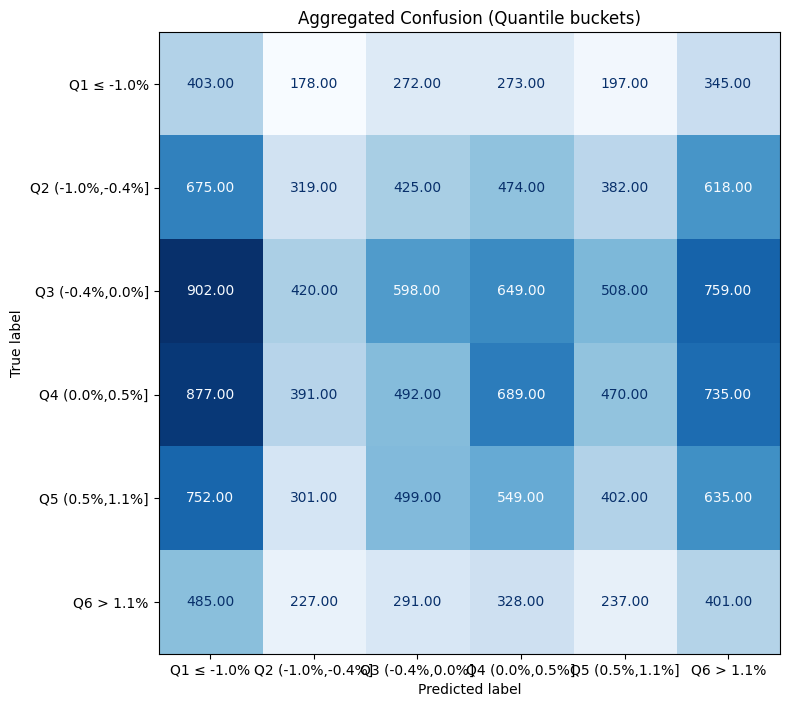

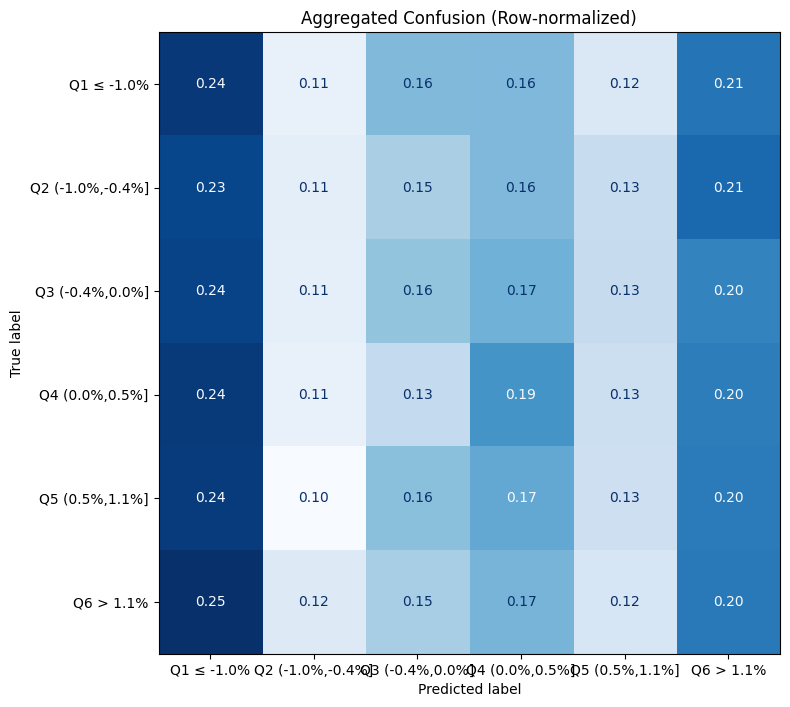

Loss curves saved to results/benchmarking/multiclass/LSTM_loss_curves.csv


In [18]:

print(f"\n{'='*25}\n  RUNNING PIPELINE FOR: LSTM\n{'='*25}\n")

pipeline_LSTM = StockPredictionPipeline(
    df=master_df,
    feature_columns=feature_columns,
    model_type='LSTM',
    sequence_length=sequence_length,
    problem_type='multiclass',
    horizon_steps=1,
    n_classes = 6
)

results_LSTM = pipeline_LSTM.run_pipeline()

if results_LSTM is not None and not results_LSTM.empty:
    analysis_LSTM = pipeline_LSTM.analyze_results()
    pipeline_LSTM.save_results(results_LSTM, output_dir='results/benchmarking/')

    all_pipelines["LSTM"] = pipeline_LSTM
    all_results_dfs["LSTM"] = results_LSTM
    all_analyses["LSTM"] = analysis_LSTM

    print("\nDisplaying first 5 rows of LSTM results:")
    display(results_LSTM.head())
else:
    print(f"\n[FAILED] Pipeline for LSTM did not produce any results.")

if pipeline_LSTM.problem_type in ['classification', 'multiclass']:
   agg_cm, q_labels, interval_labels, display_labels = aggregate_confusions_with_median_edges(results_LSTM)
if agg_cm is not None:
    plot_confusion(agg_cm, display_labels, title="Aggregated Confusion (Quantile buckets)")
    agg_norm = agg_cm / agg_cm.sum(axis=1, keepdims=True).clip(min=1)
    plot_confusion(agg_norm, display_labels, title="Aggregated Confusion (Row-normalized)")


    
loss_df = pipeline_LSTM.get_loss_curves_df()

pipeline_LSTM.save_loss_curves('results/benchmarking/')

del pipeline_LSTM